<a href="https://colab.research.google.com/github/Ping-YUAN/heartbeat-analysis-ai/blob/DataViz_MIT_Sepideh/src/features/build_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Check enviroment **
Set data_path to make this notebooks works well not only on local but also on Google drive


In [1]:
import sys
import os
data_path = ''
# Check if the environment is Google Colab
if 'google.colab' in sys.modules:
    print("Running on Google Colab")
    # Install required libraries
    # !pip install tensorflow -q
    # !pip install keras -q
    # !pip install scikit-learn -q
    # !pip install pandas -q
    # !pip install numpy -q
    # !pip install matplotlib -q
    !pip install umap-learn

    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    # set the path where the csv file stored in your own google drive.
    data_path = '/content/drive/MyDrive/Heartbeat_Project/'

else:
    print("Running on local environment")

    current_path = os.getcwd()
    print("Current working directory:", current_path)
    data_path = '../data/raw/'

Path = dict({
    'mitbih_test': data_path +  'mitbih_test.csv',
    'mitbih_train': data_path +  'mitbih_train.csv',
    'mitbih_train_clean': data_path +  'mitbih_train_clean.csv',
    'mitbih_test_clean': data_path +  'mitbih_test_clean.csv',
    'ptbdb_normal': data_path +  'ptbdb_normal.csv',
    'ptbdb_abnormal':  data_path + 'ptbdb_abnormal',
})

Running on Google Colab
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.6 MB/s eta 0:00:00
Mounted at /content/drive


# **Import the necessary packages and define the paths:**

In [2]:

# Verify installation and import libraries
import tensorflow as tf
import keras
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
from matplotlib.colors import ListedColormap
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from scipy.stats import kstest

# **Import our clean data set**

target
0    0.893347
1    0.106653
Name: proportion, dtype: float64
target
0    0.893216
1    0.106784
Name: proportion, dtype: float64


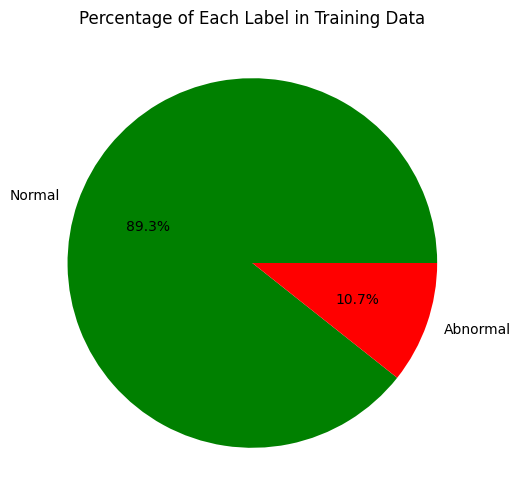

In [3]:
mitbih_train = pd.read_csv(Path.get('mitbih_train_clean'), header=0)
mitbih_test = pd.read_csv(Path.get('mitbih_test_clean'), header=0)

# Show the distribution of the two classes
print(mitbih_train['target'].value_counts(normalize=True))
print(mitbih_test['target'].value_counts(normalize=True))


label_counts = mitbih_train['target'].value_counts(normalize=True)
colors = ['green', 'red']
labels = ['Normal', 'Abnormal']

# Plot a pie chart
plt.figure(figsize=(10, 6))
plt.pie(label_counts, labels=labels, colors=colors, autopct='%1.1f%%')
plt.title('Percentage of Each Label in Training Data')
plt.show()

# after appling any redampling method on our training data, we should split our data to features(X), target(y) and train and test data. in our dataset we have train and test data then we should only define our X,y
# split the training and test data to X,y
X_train= mitbih_train.drop(columns=['target'])
y_train = mitbih_train['target']

X_test = mitbih_test.drop(columns=['target'])
y_test = mitbih_test['target']


In [4]:
# to find the distribution of our variables, follow the normal distribution or not
normal_vars = []
non_normal_vars = []

for i in range(187):  # 0 to 186
    stat, p = kstest(X_train.iloc[:, i], 'norm')
    if p > 0.05:
        normal_vars.append(f'Variable {i}')
    else:
        non_normal_vars.append(f'Variable {i}')

print("Variables following normal distribution:")
print(normal_vars)
if len(non_normal_vars) == 187:
    print("All variables not following normal distribution, then we can decide that MinMaxScalar or RobustScalar could be the best scaling method")

# create a grid of Q-Q plots, to visualize the distribution of all variables

# num_vars = 187
# num_cols = 6  # Number of columns in the grid
# num_rows = num_vars // num_cols + (num_vars % num_cols > 0)

# fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 3))

# for i in range(num_vars):
#     row = i // num_cols
#     col = i % num_cols
#     ax = axes[row, col]
#     stats.probplot(X_train.iloc[:, i], dist="norm", plot=ax)
#     ax.set_title(f'Variable {i}')

# # Hide any empty subplots
# for j in range(i + 1, num_rows * num_cols):
#     fig.delaxes(axes.flatten()[j])

# plt.tight_layout()
# plt.show()


Variables following normal distribution:
[]
All variables not following normal distribution, then we can decide that MinMaxScalar or RobustScalar could be the best scaling method


# **Rescaling**

In [ ]:
# Define recommended scalers
scalers = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "RobustScaler": RobustScaler()
}

# Define models to evaluate


models = {
    "LogisticRegression": LogisticRegression(class_weight='balanced', max_iter=1000),
    "RandomForest": RandomForestClassifier(class_weight='balanced'),
    "SVM": SVC(class_weight='balanced'),
    "KNN": KNeighborsClassifier(),
    "GradientBoosting": GradientBoostingClassifier()
}

def evaluate_scalers(X, y, scalers, models):
    results = {}
    for scaler_name, scaler in scalers.items():
        print(f"Scaler: {scaler_name}", end="\n\n")
        X_scaled = scaler.fit_transform(X)

        # # Visual inspection of the scaled data distribution
        # plt.figure(figsize=(12, 6))
        # sns.boxplot(data=X_scaled)
        # plt.title(f'{scaler_name} Data Distribution')
        # plt.show()

        skf = StratifiedKFold(n_splits=5)

        for model_name, model in models.items():
            f_score = []
            print(f"Model: {model_name}", end="\n\n")

            for train_index, test_index in skf.split(X_scaled, y):
                X_train_, y_train_ = X_scaled[train_index], y[train_index]
                X_test_, y_test_ = X_scaled[test_index], y[test_index]

                model.fit(X_train_, y_train_)

                y_pred_ = model.predict(X_test_)

                f_score.append(f1_score(y_test_, y_pred_))

            mean_f1_score = np.mean(f_score)
            print("The scores: ", end="\n\n")
            print([round(f, 2) for f in f_score], end="\n\n")
            print('F1-Score mean=%.5f' % (mean_f1_score), end="\n\n")

            if scaler_name not in results:
                results[scaler_name] = {}
            results[scaler_name][model_name] = mean_f1_score
    return results

# Apply evaluation
results = evaluate_scalers(X_train, y_train, scalers, models)
# Summarize the results
for scaler_name, model_scores in results.items():
    print(f"Scaler: {scaler_name}")
    for model_name, score in model_scores.items():
        print(f"  Model: {model_name}, F1-Score mean: {score:.5f}")
    print("\n")


Scaler: StandardScaler

Model: LogisticRegression

The scores: 

[0.18, 0.46, 0.5, 0.48, 0.42]

F1-Score mean=0.40925

Model: RandomForest



# **Apply the best rescaling method**

In [ ]:
# Initialize the scaler
scaler =MinMaxScaler()

# Fit the scaler on the training data
scaler.fit(X_train)

# Transform both the training and test data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)